<a href="https://colab.research.google.com/github/DavidAtRedpine/EigenfaceGuessTheCeleb/blob/main/EigenfaceGuessTheCeleb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Install Required Libraries

In [33]:
!pip install datasets pyarrow fsspec pillow matplotlib scikit-learn huggingface_hub

from google.colab import files
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from huggingface_hub import hf_hub_download
from datasets import load_dataset

Step 2: Load the Dataset from Hugging Face

In [26]:

# Download the Parquet file from the correct subdirectory
parquet_file = hf_hub_download(repo_id="theneuralmaze/celebrity_faces", filename="data/train-00000-of-00001.parquet", repo_type="dataset")

# Confirm the file was downloaded
print(f"Downloaded file: {parquet_file}")

# Load the Parquet file as a dataset
dataset = load_dataset("parquet", data_files=parquet_file, split="train")

# Confirm the dataset structure
print(dataset)

# Extract processed data
image_data = np.stack(dataset['image'])  # Images as flattened arrays
celebrity_names = np.array(dataset['label'])  # Labels (celebrity names)

print(f"Processed {image_data.shape[0]} celebrity images with {image_data.shape[1]} pixels each.")

print ("Celebrities include...")
# range from 0 to length of celebrity_names or 20, whichever is smaller
for i in range(min(20, len(celebrity_names))):
  print (celebrity_names[i])


Downloaded file: /root/.cache/huggingface/hub/datasets--theneuralmaze--celebrity_faces/snapshots/f82c306895067c4ce9d6910214e6f802591ec42f/data/train-00000-of-00001.parquet
Dataset({
    features: ['image', 'label'],
    num_rows: 3000
})
Processed 3000 images with 160 pixels each.
Celebrities include...
Jason Momoa
Krysten Ritter
alycia dabnem carey
Millie Bobby Brown
Miley Cyrus
Maisie Williams
Taylor Swift
Logan Lerman
Brenton Thwaites
Tom Holland
Maisie Williams
Alexandra Daddario
Nadia Hilker
Mark Zuckerberg
Keanu Reeves
Zac Efron
Nadia Hilker
elizabeth olsen
Inbar Lavi
Henry Cavil


Step 4: Compute Eigenfaces using PCA

In [13]:
num_components = 50  # Number of principal components (eigenfaces)

def preprocess_image(example):
    image = example['image'].convert('L')  # Convert to grayscale
    resized_image = image.resize((100, 100))  # Force resize to 100x100
    return {'image_array': np.array(resized_image).flatten() / 255.0}  # Flatten and normalize

# Apply preprocessing
dataset = dataset.map(preprocess_image)

# Re-check image data
image_data = np.stack(dataset['image_array'])  # Flattened arrays
print("Shape of image_data:", image_data.shape)  # Should be (N, 10000)

mean_face = np.mean(image_data, axis=0)
centered_data = image_data - mean_face
centered_data = centered_data.reshape(centered_data.shape[0], -1)

pca = PCA(n_components=num_components)
pca.fit(centered_data)
eigenfaces = pca.transform(centered_data)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Shape of image_data: (3000, 10000)


Step 5: Visualize the mean face and some eigenfaces

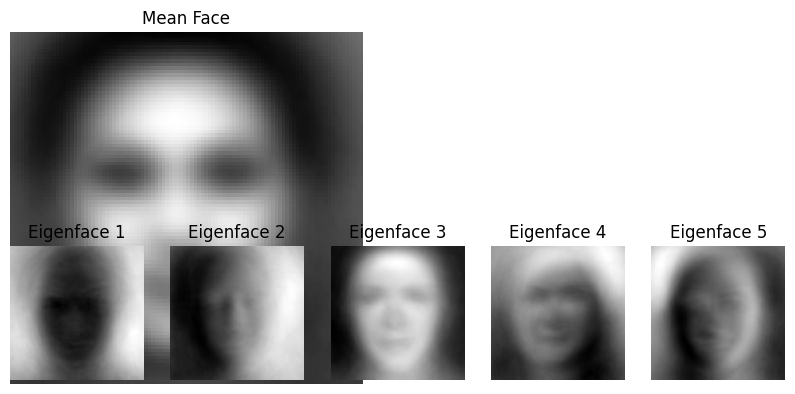

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mean_face.reshape((100, 100)), cmap='gray')
plt.title("Mean Face")
plt.axis('off')

for i in range(5):  # Display the first 5 eigenfaces
    plt.subplot(2, 5, i+6)
    plt.imshow(pca.components_[i].reshape((100, 100)), cmap='gray')
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.show()


Step 6: Build a Recognition System

In [15]:
face_projections = pca.transform(centered_data)

Step 7: Test the Recognition System

In [32]:
uploaded = files.upload()  # Opens a dialog to upload an image file

# Load and preprocess the test image
uploaded_image_path = list(uploaded.keys())[0]  # Get the uploaded file's name
test_image = Image.open(uploaded_image_path).convert('L')  # Convert to grayscale
test_image = test_image.resize((100, 100))  # Resize to match training images
test_face = np.array(test_image).flatten() / 255.0  # Normalize and flatten

def predict_celebrity(new_face, face_projections, celebrity_names, mean_face, pca, k=1):
    new_face = new_face.flatten() - mean_face  # Preprocess the new face
    new_projection = pca.transform(new_face.reshape(1, -1))  # Project into eigenface space
    distances = pairwise_distances(new_projection, face_projections, metric='euclidean')
    closest_indices = np.argsort(distances[0])[:k]
    closest_celebs = celebrity_names[closest_indices]
    return closest_celebs, distances[0, closest_indices]

# Test the Recognition System
predicted_celeb, similarity_scores = predict_celebrity(test_face, face_projections, celebrity_names, mean_face, pca)

print(f"Predicted Celebrity: {predicted_celeb[0]} with similarity score {similarity_scores[0]}")

plt.figure(figsize=(5, 5))
plt.imshow(test_face.reshape((100, 100)), cmap='gray')
plt.title(f"Predicted: {predicted_celeb[0]}")
plt.axis('off')
plt.show()

Saving mark.png to mark (1).png
Predicted Celebrity: Jake Mcdorman with similarity score 16.375507236496958


IndexError: index 1 is out of bounds for axis 0 with size 1